Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.8748 - loss: 0.4076 - val_accuracy: 0.9814 - val_loss: 0.0594
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9832 - loss: 0.0540 - val_accuracy: 0.9857 - val_loss: 0.0443
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9881 - loss: 0.0375 - val_accuracy: 0.9878 - val_loss: 0.0379
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.9922 - loss: 0.0268 - val_accuracy: 0.9890 - val_loss: 0.0350
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9932 - loss: 0.0216 - val_accuracy: 0.9880 - val_loss: 0.0365
Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 53s 54ms/step - accuracy: 0.7848 - loss: 0.6629 - val_accuracy: 0.9840 - val_loss: 0.0489
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 55s 59ms/step - accuracy: 0.9606 - loss: 0.1261 - val_accuracy: 0.9848 - val_loss: 0.0449
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 55s 59ms/step - accuracy: 0.9719 - loss: 0.0909 - val_a

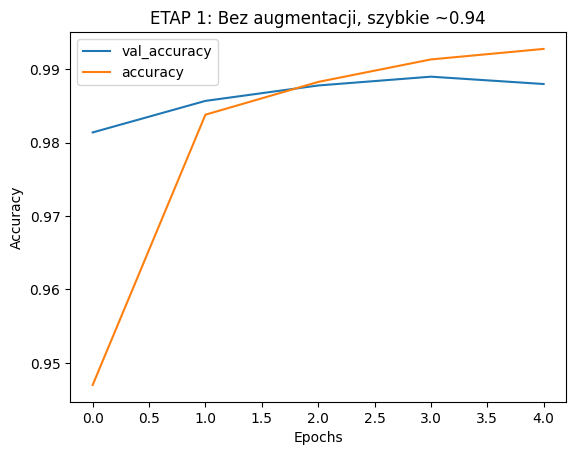

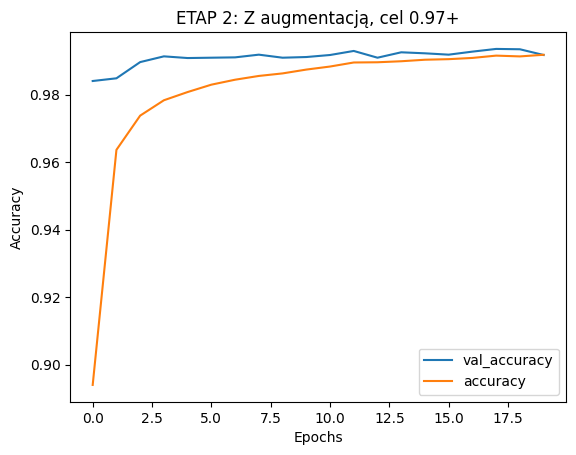

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9857 - loss: 0.0450
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9905 - loss: 0.0328
ETAP 1 - Test Accuracy: 0.9880
ETAP 2 - Test Accuracy: 0.9917


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 1️⃣ Załaduj dane MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizacja i reshaping (MNIST ma grayscale 28x28)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Funkcja budująca model
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 🚩 ETAP 1: Szybkie osiągnięcie 0.94 bez augmentacji
model1 = build_model()
history1 = model1.fit(x_train, y_train, epochs=5, batch_size=64,
                      validation_data=(x_test, y_test))



# 🚩 ETAP 2: Trenowanie z augmentacją, cel: 0.97+
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1
)
datagen.fit(x_train)

model2 = build_model()
history2 = model2.fit(datagen.flow(x_train, y_train, batch_size=64),
                      epochs=20,
                      validation_data=(x_test, y_test))

# 🚩 Wizualizacja przebiegu uczenia
def plot_history(history, title):
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history1, 'ETAP 1: Bez augmentacji, szybkie ~0.94')
plot_history(history2, 'ETAP 2: Z augmentacją, cel 0.97+')

# 🚩 Finalne oceny
test_loss1, test_acc1 = model1.evaluate(x_test, y_test)
test_loss2, test_acc2 = model2.evaluate(x_test, y_test)

print(f"ETAP 1 - Test Accuracy: {test_acc1:.4f}")
print(f"ETAP 2 - Test Accuracy: {test_acc2:.4f}")


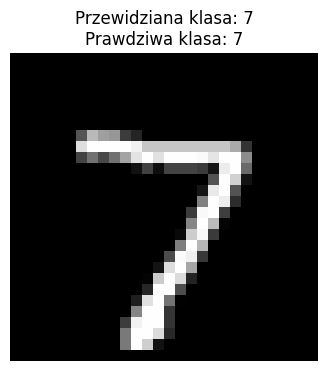

Przewidziana klasa: 7, Prawdopodobieństwa: [1.17049382e-13 2.32098674e-09 6.84516126e-05 2.17380943e-06
 3.32852537e-08 8.69855160e-11 1.37783001e-13 9.99929190e-01
 1.02497415e-08 1.65357136e-07]


In [7]:
# Interfejs predykcji z @tf.function
@tf.function
def predict_fn(model, image):
    return model(image, training=False)

def predict_and_visualize(model, image, true_label):
    class_names = [str(i) for i in range(10)]  # 0-9 dla MNIST

    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.reshape(image, [1, 28, 28, 1])
    prediction = predict_fn(model, image)
    predicted_class = tf.argmax(prediction[0]).numpy()
    
    plt.figure(figsize=(4, 4))
    plt.imshow(tf.reshape(image, [28, 28]), cmap='gray')
    plt.title(f'Przewidziana klasa: {class_names[predicted_class]}\nPrawdziwa klasa: {class_names[true_label]}')
    plt.axis('off')
    plt.show()
    
    return predicted_class, prediction[0].numpy()

# Przykład predykcji i wizualizacji
sample_idx = 0  # lub dowolny inny indeks
sample_image = x_test[sample_idx]   # poprawione z X_test
sample_label = y_test[sample_idx]
pred_class, pred_probs = predict_and_visualize(model2, sample_image, sample_label)

print(f"Przewidziana klasa: {pred_class}, Prawdopodobieństwa: {pred_probs}")
